In [176]:
import numpy as np
import pandas as pd
from io import StringIO
from scipy.spatial import cKDTree # create KDTree
import matplotlib.pyplot as plt

import fafbseg # API
from fafbseg import flywire
import caveclient

import networkx as nx # create tree based on SWC
import navis

import jax
import jaxley as jx
import jax.numpy as jnp # numpy in jax
from jaxley.channels import Na, K, Leak # Mechanism

from jax import config # Device
config.update("jax_platform_name", "cpu")
config.update("jax_enable_x64", True)
#print(jax.devices())


from jax import jit, vmap, value_and_grad # Simulation and optimization
import optax
import tensorflow as tf
from tensorflow.data import Dataset

In [177]:
# Define the SWC content
swc_content = """\
1 1 0.0 0.0 0.0 1.0 -1
2 0 1.5 0.0 0.0 1.0 1
3 0 3.5 0.5 0.0 1.0 2
4 0 4.0 1.5 0.0 1.0 3
5 0 5.5 2.0 0.0 1.0 4
6 0 7.0 3.0 0.0 1.0 5
7 0 8.0 5.0 0.0 1.0 6
8 0 9.0 7.0 0.0 1.0 7
9 0 9.5 9.0 0.0 1.0 8
10 0 7.0 -1.0 0.0 1.0 6
11 0 6.0 -2.5 0.0 1.0 10
12 0 5.0 -4.0 0.0 1.0 11
13 0 8.0 2.5 0.0 1.0 5
14 0 9.5 3.5 0.0 1.0 13
15 0 11.0 4.0 0.0 1.0 14
16 0 4.0 0.5 0.0 1.0 4
17 0 4.5 1.0 0.0 1.0 16
18 0 5.0 1.5 0.0 1.0 17
19 0 3.5 -1.0 0.0 1.0 16
20 0 2.0 -2.0 0.0 1.0 19
21 0 1.0 -3.0 0.0 1.0 20
"""

# Write to a file
with open("minSWC.swc", "w") as f:
    f.write(swc_content)


c:\Users\Venom\anaconda3\envs\Jax\Lib\site-packages\jaxley\utils\swc.py:32: UserWarning: Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.
  warn(


,comp_index,branch_index,cell_index,length,radius,axial_resistivity,capacitance,v
0,0,0,0,2.000000,1.0,5000.0,1.0,-70.0
1,1,1,0,3.179587,1.0,5000.0,1.0,-70.0
2,2,2,0,1.581139,1.0,5000.0,1.0,-70.0
3,3,3,0,1.000000,1.0,5000.0,1.0,-70.0
4,4,4,0,1.802776,1.0,5000.0,1.0,-70.0
5,5,5,0,5.933424,1.0,5000.0,1.0,-70.0
6,6,6,0,6.533689,1.0,5000.0,1.0,-70.0
7,7,7,0,7.605551,1.0,5000.0,1.0,-70.0
8,8,8,0,1.414214,1.0,5000.0,1.0,-70.0
9,9,9,0,4.798128,1.0,5000.0,1.0,-70.0


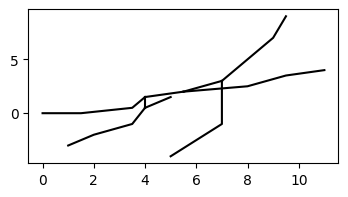

In [178]:
cell = jx.read_swc("minSWC.swc", nseg=1, assign_groups=False)
cell.compute_xyz()  # Only needed for visualization.
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = cell.vis(ax=ax, col="k")
cell.show()

In [179]:
column_names = ["Index", "Type", "X", "Y", "Z", "Radius", "Parent"]
df = pd.read_csv("minSWC.swc", delim_whitespace=True, names=column_names)[["Index", "Parent"]]
df_full = pd.read_csv("minSWC.swc", delim_whitespace=True, names=column_names)

In [180]:
tree = nx.DiGraph()
for _, row in df.iterrows():
    node = row["Index"]
    parent = row["Parent"]
    if (parent != -1):
        tree.add_edge(parent, node)
    else:
        tree.add_node(node)

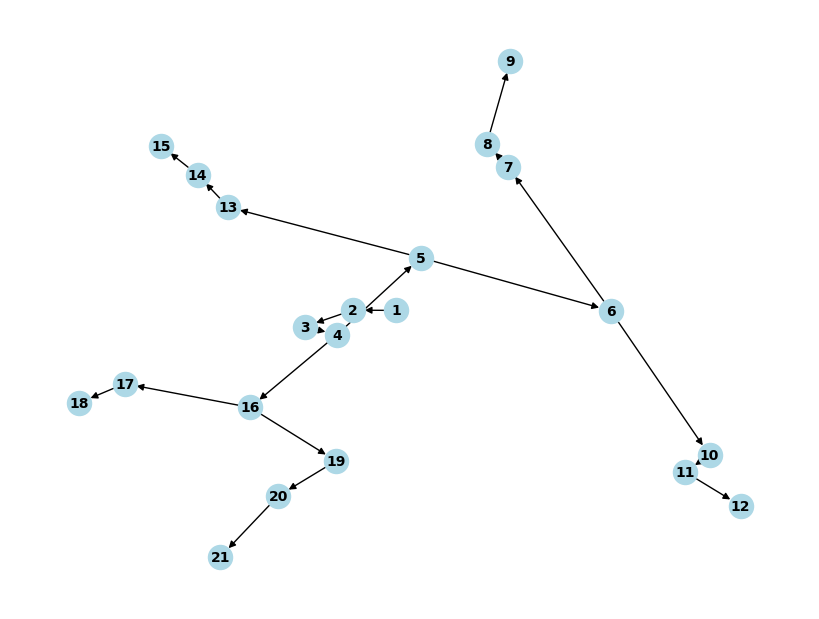

In [181]:
plt.figure(figsize=(8, 6))  # Set the figure size
pos = nx.spring_layout(tree)  # You can use different layouts like spring_layout, planar_layout, etc.
nx.draw(tree, pos, with_labels=True, node_size=300, node_color="lightblue", font_size=10, font_weight="bold")
plt.show()

In [182]:
import networkx as nx

def dfs_with_compartments(graph, start_node):
    node_to_compartment = {}
    visited = set()
    traversal_order = []  # List to store compartments
    compartment = []  # Temporary list to store the current series of nodes
    stack = [start_node]  # Stack for DFS traversal
    branching_stack = []  # Stack to track branching points
    soma_connection = set()

    while stack:
        node = stack.pop()

        if node not in visited:
            visited.add(node)

            # Prepend the compartment with prior branching point
            if (not compartment and node != 1 and list(graph.predecessors(node))[0] !=1):
                compartment.append(list(graph.predecessors(node))[0])
            compartment.append(node)
            
            if (node != 1 and list(graph.predecessors(node))[0] == 1):
                soma_connection.add(node)
                
            
            # Get all unvisited children of the current node
            children = sorted([child for child in graph.successors(node) if child not in visited])

            if len(children) > 1:
                # If the current node is a branching point, push it to the branching stack
                branching_stack.append(node)
                traversal_order.append(compartment)
                compartment = []

            if len(children) == 0:
                # If the current node has no children, we've reached the end of a compartment
                traversal_order.append(compartment)  # Save the current compartment
                compartment = []  # Start a new compartment

                # If there are still branching points to backtrack to, backtrack
                if branching_stack:
                    stack.append(branching_stack.pop())

            else:
                # If there are children, continue the DFS
                stack.extend(reversed(children))  # Add children to the stack in reverse order

    return traversal_order, soma_connection

result, soma_connection = dfs_with_compartments(tree, 1)
result.insert(1, result[0][1:])
result[0] = [1]
result_compartment = sorted(result, key=lambda x: (x[0], x[1] if len(x) > 1 else float('inf')))
print("Compartments:", result_compartment)


node_mapping = {}
start_node_mapping = {}
processed = set()

for index, lst in enumerate(result_compartment):
    if lst[0] not in processed:
        node_mapping[lst[0]] = index
        processed.add(lst[0])  # Mark the first number as processed
    for number in lst[1:]:  # Process the remaining numbers
        if number not in processed:
            node_mapping[number] = index
            processed.add(number)

print("Node mapping:", node_mapping)

print("Soma connection:", soma_connection)

Compartments: [[1], [2, 3, 4], [4, 5], [4, 16], [5, 6], [5, 13, 14, 15], [6, 7, 8, 9], [6, 10, 11, 12], [16, 17, 18], [16, 19, 20, 21]]
Node mapping: {1: 0, 2: 1, 3: 1, 4: 1, 5: 2, 16: 3, 6: 4, 13: 5, 14: 5, 15: 5, 7: 6, 8: 6, 9: 6, 10: 7, 11: 7, 12: 7, 17: 8, 18: 8, 19: 9, 20: 9, 21: 9}
Soma connection: {2}


In [183]:
def node_seg (node):
    length = 0
    compartment_index = node_mapping[node]
    compartment = result_compartment[compartment_index]
    for i in range (len(compartment) - 1):
        if (compartment[i] != node):
            coord_start = df_full.iloc[compartment[i] - 1][["X", "Y", "Z"]].values
            coord_end = df_full.iloc[compartment[i + 1] - 1][["X", "Y", "Z"]].values
            length += (np.linalg.norm (coord_end - coord_start))
        else:
            return length
    return length

In [184]:
print(node_seg(16)) # = 1 because it is on 1.0 position of compartment [4, 16]: we don't consider it to be starting node except when it appeared nowhere else
print(node_seg(4)) # = 3.17
print(node_seg(2)) # = 0 because it appeared nowhere else but first node of compartment [2, 3, 4]
print(node_seg(8))
print(node_seg(11))

1.0
3.179586801558725
0
4.47213595499958
5.802775637731995


In [185]:
def path_length (node1, node2):
    print ("first time seeing nodes:")
    print ("nodes:", node1, node2)
    path_length = 0
    compartment_index1 = node_mapping[node1]
    compartment_index2 = node_mapping[node2]

    if (compartment_index1 != compartment_index2):

        path_length += node_seg(node1) + node_seg(node2)
        node1 = result_compartment[compartment_index1][0]
        node2 = result_compartment[compartment_index2][0]
        print ("clear whatever is remaining in compartment")
        print ("nodes:", node1, node2)

        while (node1 != node2):
            if (node1 < node2): # if we want to update node2
                if (node2 in soma_connection):
                    coord_start = df_full.iloc[node2 - 1][["X", "Y", "Z"]].values
                    coord_end = df_full.iloc[0][["X", "Y", "Z"]].values
                    path_length += (np.linalg.norm (coord_end - coord_start))
                    compartment_index2 = 0
                    node2 = 1
                else:
                    path_length += node_seg(node2)
                    compartment_index2 = node_mapping[node2]
                    node2 = result_compartment[compartment_index2][0]
                    print ("updated nodes by changing node2")
                    print ("nodes:", node1, node2)

            elif (node1 > node2):
                if (node1 in soma_connection):
                    coord_start = df_full.iloc[node1 - 1][["X", "Y", "Z"]].values
                    coord_end = df_full.iloc[0][["X", "Y", "Z"]].values
                    path_length += (np.linalg.norm (coord_end - coord_start))
                    compartment_index1 = 0
                    node1 = 1
                else:
                    path_length += node_seg(node1)
                    compartment_index1 = node_mapping[node1]
                    node1 = result_compartment[compartment_index1][0]
                    print ("updated nodes by changing node1")
                    print ("nodes:", node1, node2)
                    
    else:
        path_length = np.abs(node_seg(node1) - node_seg(node2))
    
    return path_length
    
path_length (6, 16)

first time seeing nodes:
nodes: 6 16
clear whatever is remaining in compartment
nodes: 5 4
updated nodes by changing node1
nodes: 4 4


4.383914467816185

In [186]:
lengths = [df_full.iloc[0]["Radius"] * 2]
for compartment in result_compartment[1:]:
    length = 0
    for i in range (len(compartment) - 1):
        coord_start = df_full.iloc[compartment[i] - 1][["X", "Y", "Z"]].values
        coord_end = df_full.iloc[compartment[i + 1] - 1][["X", "Y", "Z"]].values
        length += (np.linalg.norm (coord_end - coord_start))
    lengths.append(length)
predict_length = np.array(lengths)
predict_length

array([2.        , 3.1795868 , 1.58113883, 1.        , 1.80277564,
       5.93342422, 6.53368877, 7.60555128, 1.41421356, 4.79812803])

In [187]:
actual_length = cell.show()["length"].values
actual_length

array([2.        , 3.1795868 , 1.58113883, 1.        , 1.80277564,
       5.93342422, 6.53368877, 7.60555128, 1.41421356, 4.79812803])

In [188]:
tolerance = 0.01
result = np.allclose(predict_length, actual_length, atol=tolerance)

print("Arrays match within tolerance:", result)

Arrays match within tolerance: True
